In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras import Model
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.optimizers import adam_v2
from matplotlib import pyplot as plt

2023-02-12 17:32:05.111927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 17:32:05.263655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-12 17:32:05.263680: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-12 17:32:06.046205: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Get test data

In [2]:
train_df = pd.read_csv('training_6_category_1/preprocessed.csv')
train_df['type_sensor_1'] = train_df['type_sensor_1'].astype('category')
train_df['type_sensor_2'] = train_df['type_sensor_2'].astype('category')
train_df['type_sensor_3'] = train_df['type_sensor_3'].astype('category')

X = train_df.drop(columns=['latitude_aircraft', 'longitude_aircraft', 'geoAltitude', 'baroAltitude'])
Y = train_df[['latitude_aircraft', 'longitude_aircraft', 'geoAltitude', 'baroAltitude']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Tensorflow

Evaluate different DNN

In [3]:
def get_wide_model(input_shape, nodes):
    input_tensor = Input(shape=input_shape)
    drop_out_tensor = Dropout(.2)(input_tensor)
    hidden_tensor = Dense(nodes)(drop_out_tensor)
    output_tensor = Dense(len(Y.columns))(hidden_tensor)
    model = Model(input_tensor, output_tensor)

    return model

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
optimizer = adam_v2.Adam(learning_rate=0.001)
histories = []
nodes = [100, 200, 250, 300]

In [5]:
for num in nodes:
    model_checkpoint = ModelCheckpoint(''.join(['best_aircraft_model', str(num), '.hdf5']), save_best_only = True)
    wide_model = get_wide_model((len(X.columns),), num)
    wide_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    histories.append(wide_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint]))

2023-02-12 17:32:18.722810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-12 17:32:18.722836: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 17:32:18.722858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lisbert-TP): /proc/driver/nvidia/version does not exist
2023-02-12 17:32:18.723063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
28252/28252 [==============================] - 46s 2ms/step - loss: 7612078.5000 - root_mean_squared_error: 2758.9998 - val_loss: 4825424.0000 - val_root_mean_squared_error: 2196.6848

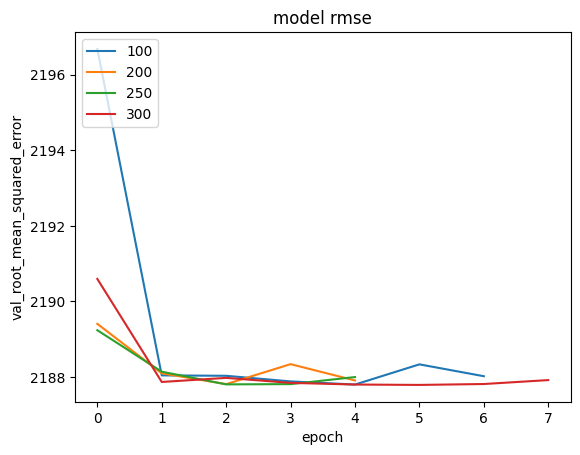

In [6]:
plt.figure()
for i, mh in enumerate(histories):
    plt.plot(mh.history['val_root_mean_squared_error'])
plt.title('model rmse')
plt.ylabel('val_root_mean_squared_error')
plt.xlabel('epoch')
plt.legend([100, 200, 250, 300], loc='upper left')
plt.savefig('plots/rmse_wide.svg', format='svg')
plt.show()

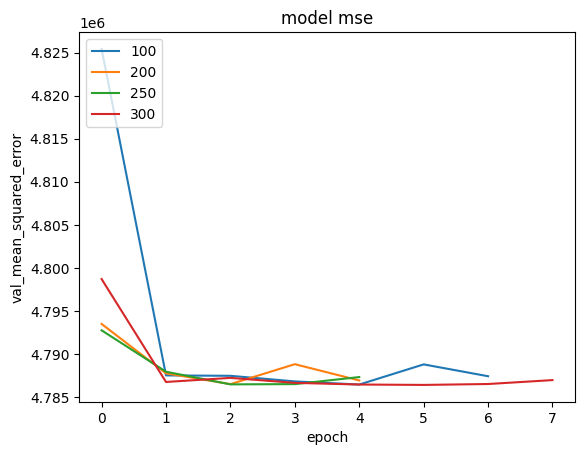

In [7]:
plt.figure()
for i, mh in enumerate(histories):
    plt.plot(mh.history['val_loss'])
plt.title('model mse')
plt.ylabel('val_mean_squared_error')
plt.xlabel('epoch')
plt.legend([100, 200, 250, 300], loc='upper left')
plt.savefig('plots/mse_wide.svg', format='svg')
plt.show()
